In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score

from cleaning import df
sns.set()

Based on my EDA, there are some columns I am going to drop from my dataset due to strong multicollinearity and statistics that inform the other. I will be dropping `pts` which is a combination of `twop`, `threep`, and `ft`. Additionally, this will help me see if there are meaningful differences in how different scoring methods affect a player's likelihood to be an allstar. I am dropping `trb` because it is the combined total of `drb` and `orb`. I will also be dropping `fgp`, `twopp`, `threepp`, and `ftp` because they are calculated from using makes divided by attempts.

In [2]:
df = df.drop(columns=['pts', 'trb', 'fgp', 'twopp', 'threepp', 'ftp'])

I want to set up a pipeline that performs GridSearchCV on every step from Feature Selection, Hyperparameter Tuning, and Learning Model Selection.

Feature Selection:
- `VarianceThreshold`
- `SelectKBest`
- `SelectFromModel`

Hyperparameter Tuning:
- `GridSearchCV`

Learning Model Selection:
- `LogisticRegression`
- `RandomForestClassifier`
- `SVM`
- `KNNeighborsClassifier`


Metrics:
- ROC-AUC
- F1 Score



# Feature Selection
There are 3 different methods of feature selection that I will consider: `VarianceThreshold`, `SelectKBest`, and `SelectFromModel`.

`VarianceThreshold` removes all features with a variance equal to 0. Since I do not have any columns with the same values throughout, this will not help me reduce the dimensionality of my dataset.

`SelectKBest` selects a defined number of categories, k, that are most descriptive of the data. For classification problems, there are 3 types of tests that can be run to score the features: `chi2`, `f_classif`, and `mutual_info_classif`. `chi2` uses a $\chi^{2}$ test to measure dependence between stochastic varables, so this function removes features that are most likely to be independent of class and therefore irrelevant to classification. However, it requires all positive values, and when I scale my data, some values are below 0.  `f_classif` calculates the ANOVA F-value for the sample which is the ratio of two features' variance. `mutual_info_classif` estimates mutual information for a discrete target variable. If MI between two random variables is 0, they are independent, and a high MI means higher dependency.

For my purposes, I will use `SelectKBest` and use `mutual_info_classif` to determine the best features.

To begin, I set `int_df` equal to the numeric columns of my dataset. I then split it into the feature columns and the target column, `allstar_next`. I then separate each of these new dataframes into training datasets and test datasets. I use StandardizedScaler to preprocess the feature dataset. The target data is binary so no standardization is necesary.

In order to prevent leakage in my model, I fit it to the training set ONLY, and then use this fitted model to transform both the training and test sets.

In [3]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)


skb = SelectKBest(mutual_info_classif, k=features.shape[1])
skb.fit(Xtrain, ytrain)
mask = skb.get_support()
kbestfeat = list()

for boolean, feature in zip(mask, int_df.columns):
    if boolean:
        kbestfeat.append(feature)

NameError: name 'mutual_info_classif' is not defined

In [ ]:
indices = np.argsort(skb.scores_)[::-1]
cols = []
for i in range(23):
    cols.append(int_df.columns[indices[i]])

# Now plot
plt.figure(figsize=[12,6])
plt.bar(cols, skb.scores_[indices[range(23)]], color='r', align='center')
plt.xticks(rotation=60)
plt.title('Best Descriptors Based on Mutual Information Score', size=20)
plt.xlabel('Feature')
plt.ylabel('Mutual Information')
plt.show()

My 10 most descriptive features are: `fta`, `ft`, `twop`, `fg`, `twopa`, `allstar`, `fga`, `mp`, `tov`, and `gs`. However, I don't know if feature selection is even the best option for me. In order to check this, I will run some tests on the ability of my model to correctly predict my data using different number of features

In [ ]:
from sklearn.metrics import f1_score

scaler = StandardScaler()
lr = LogisticRegression(max_iter=10000, solver='lbfgs')
pipeline = make_pipeline(scaler, lr)

f1s = []
for i in range(1, len(kbestfeat)+1):
    
    features = int_df[cols[:i]].values
    target = int_df.loc[:, 'allstar_next'].values

    Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)
    
    pipeline.fit(Xtrain, ytrain)
    ypred = pipeline.predict(Xtest)
    
    f1s.append(f1_score(ytest, ypred))
    
plt.figure(figsize=(12,6))
plt.bar(x=range(1, len(kbestfeat)+1), height=f1s);
plt.title('F1 Scores for Different Number of Features', size=20);
plt.xlabel('Number of Features');
plt.ylabel('F1 Score');

Since there is an initial increase in prediction power and then very small increases with more features, I am not going to reduce the dimensionality of my dataset further than I already have. Increased information will hopefully help me tune my model more effectively.

# Logistic Regression
There are a variety of parameters for logistic regression, but many of them do not apply to my question for a variety of reasons or I have made a selection based on the scikit-learn documentation. For instance, while there are many potential solvers many do not make sense for my project. `sag` and `saga` are for very large datasets. Given that I do not have an excess of columns, I want to use L2 penalty rather than L1 which could induce too much sparsity. Using `newton-cg` comes with many problems such as being computationally expensive and being attracted to Saddle Points where it can become confused about whether the input is a maximum or minimum. This leaves me with `liblinear` and `lbfgs`. I will use `lbfgs` because it is the default setting for `LogisticRegression` and will serve my purposes well.

I have determined the following parameters to be most important for my model construction:
- `C`
- `fit_intercept`

I chose to use GridSearchCV over RandomizedSearchCV because the range of parameters and the size of my dataset is not so large as to cause problems. My scoring metric to determine the best model will be the F1 score because in my dataset, there are more seasons where the next year a player is not an allstar than there are seasons where a player is. Looking at accuracy alone would artificially inflate the models success rate.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df[kbestfeat[:10]].values
target = int_df.loc[:, 'allstar_next'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

lr = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=13)
parameters = {'C':[0.001, 0.1, 1, 10, 10e8],
              'fit_intercept': [True, False]
             }
gscv = GridSearchCV(lr, parameters, cv=5, 
                          scoring = 'f1',
                          error_score=np.nan)


In [ ]:
gscv.fit(Xtrain, ytrain)
print('Parameters:\n{}\nF1 Score:{}'.format(gscv.best_params_, 
                                            gscv.best_score_))
C = gscv.best_params_['C']
fit_intercept = gscv.best_params_['fit_intercept']

Based off of the grid search results, my parameters for the model should be:
- `C`: 10e8
- `fit_intercept`: False

I now want to test my model's effectiveness at predicting new data. Below I set up a pipeline to standardize the data and then perform logistic regression on the test samples. I will then produce a confusion matrix, classification report, and ROC curve.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next'].values
target = int_df.loc[:, 'allstar_next'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)
scaler = StandardScaler()

lr = LogisticRegression(C=C, fit_intercept=fit_intercept,
                       max_iter=10000, solver='lbfgs')

pipeline = make_pipeline(scaler, lr)

pipeline.fit(Xtrain, ytrain)
ypred = pipeline.predict(Xtest)

print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))


In [ ]:
from sklearn.metrics import roc_curve, auc

fprlr, tprlr, threshold = roc_curve(ytest, ypred)
roc_auclr = auc(fprlr, tprlr)

plt.figure(figsize=(12,6));
plt.title('Receiver Operating Characteristic: Logistic Regression', size=20);
plt.plot(fprlr, tprlr, 'b', label = 'AUC = %0.2f' % roc_auclr);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');
plt.show();

I now want to explore using a Random Forest Classifier on my data.

For this testing, I will use RandomizedSearchCV for this testing because `RandomForestClassifier` is a far more computationally expensive procedure than `LogisticRegression`.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next'].values
target = int_df.loc[:, 'allstar_next'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)

scaler = StandardScaler()
rfc = RandomForestClassifier(bootstrap=True)

param_grid = {
    'n_estimators': [10, 100, 500, 1000],
    'max_depth': [1, 2, 5, 10],
    'max_features': [1, 2, 3, 4, 5]
}

rscv = RandomizedSearchCV(rfc, n_iter=15, param_distributions=param_grid, 
                          cv=5, scoring = 'f1',
                          error_score=np.nan)

In [ ]:
rscv.fit(Xtrain, ytrain)

In [4]:
print(rscv.best_params_, rscv.best_score_)

NameError: name 'rscv' is not defined

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)

scaler = StandardScaler()
rfc = RandomForestClassifier(n_estimators=500, max_features=5,
                            max_depth=5)
pipeline = make_pipeline(scaler, rfc)

pipeline.fit(Xtrain, ytrain)
ypred = pipeline.predict(Xtest)

print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))


[[531  78]
 [ 97 259]]
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86       609
         1.0       0.77      0.73      0.75       356

    accuracy                           0.82       965
   macro avg       0.81      0.80      0.80       965
weighted avg       0.82      0.82      0.82       965



In [6]:
feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending=False)
feature_imp

allstar            0.210419
fta                0.125059
twop               0.098156
ft                 0.094258
twopa              0.085869
fg                 0.085112
mp                 0.080575
fga                0.055954
years_in_league    0.021473
tov                0.020025
age                0.016438
drb                0.016393
efgp               0.013490
gs                 0.011970
ast                0.011466
stl                0.010611
blk                0.009127
g                  0.007111
pf                 0.006872
orb                0.006290
threepa            0.005032
threep             0.004305
height             0.003996
dtype: float64

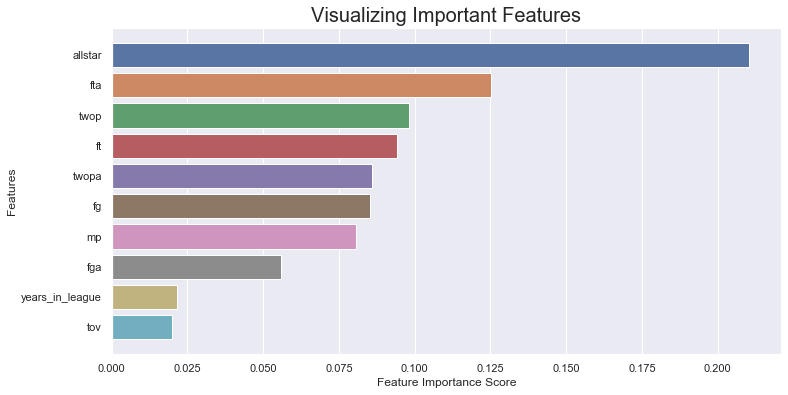

In [7]:
plt.figure(figsize=(12,6))
sns.barplot(x=feature_imp[:10], y=feature_imp[:10].index);
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');
plt.title('Visualizing Important Features', size=20);
plt.plot();

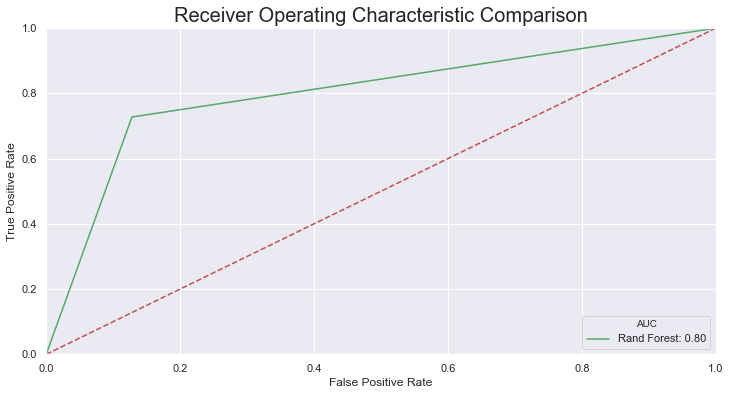

In [8]:
from sklearn.metrics import roc_curve, auc

fprrfc, tprrfc, threshold = roc_curve(ytest, ypred)
roc_aucrfc = auc(fprrfc, tprrfc)

plt.figure(figsize=(12,6))
plt.title('Receiver Operating Characteristic Comparison', size=20)
plt.plot(fprrfc, tprrfc, 'g', label='Rand Forest: %0.2f' % roc_aucrfc)
plt.legend(title='AUC', loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Based on this testing, Random Forest Classifier is worse than a Logistic Regression. I will now test Support Machine Vectors

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)

scaler = StandardScaler()
svc = SVC(gamma='scale')

param_grid = {
    'C' : [0.001, 1, 1000000],
    'kernel' : ['poly', 'rbf', 'sigmoid'],
    'degree' : [2, 3]
}

gscv = GridSearchCV(svc, param_grid, cv=5,
                    scoring = 'f1',
                    error_score=np.nan)

In [ ]:
gscv.fit(Xtrain, ytrain)

C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Drew\AppData\Ro

In [ ]:
print(gscv.best_params_, gscv.best_score_)

In [ ]:
from sklearn.metrics import roc_curve, auc

fprrfc, tprrfc, threshold = roc_curve(ytest, ypred)
roc_aucrfc = auc(fprrfc, tprrfc)

plt.figure(figsize=(12,6))
plt.title('Receiver Operating Characteristic Comparison', size=20)
plt.plot(fprlr, tprlr, 'b', label = 'Log Reg = %0.2f' % roc_auclr)
plt.plot(fprrfc, tprrfc, 'g', label='Rand Forest: %0.2f' % roc_aucrfc)
plt.legend(title='AUC', loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

I found this code at [http://www.davidsbatista.net/blog/2018/02/23/model_optimization/] which allows me to test multiple models and parameters at once.


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next'].values
target = int_df.loc[:, 'allstar_next'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

model = TSNE(learning_rate=100)
transformed = model.fit_transform(int_df)
xs = transformed[:, 0]
ys = transformed[:, 1]
_ = plt.scatter(xs, ys, c=target, cmap='plasma', alpha = 0.2)
_ = plt.show()

Next I want to look at a different 